In [14]:
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
import numpy as np
import scipy.stats as st


***Open with data***

In [15]:
with open('../DataBases/CD4EncodedBase.pkl', 'rb') as f:
    columns, Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced, Cd4AttributesTest, Cd4ClassResultsTest = pickle.load(f)
with open('../Databases/VlEncodedBase.pkl', 'rb') as f:
    columns, VlAttributesTrainingBalanced, VlClassResultsTrainingBalanced, Vl4AttributesTest, VlClassResultsTest = pickle.load(f)


***GridSearch for Random Forest***

In [16]:
params = {
    'n_estimators': [120],
    'max_depth': [5, 20, 30, None],
    'min_samples_split': [3, 5, 10, 50, 100],
    'min_samples_leaf': [3, 5, 10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', None]
}

***Creating Grid***

In [17]:
grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid=params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

***Run Grid***

In [18]:
#grid.fit(Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced)

In [19]:
#print(grid.best_params_)
#print(grid.best_score_)
#best_model = grid.best_estimator_
#best_params = grid.best_params_
best_model = RandomForestClassifier(max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120, criterion='entropy')

***k-fold***

In [21]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from copy import deepcopy

kf = KFold(n_splits=15, shuffle=True, random_state=42)
best_accuracy = 0
best_model_kfold = None

# Create an empty list to store the metrics from each fold
accuracy = []
precision_scores_class_0 = []
precision_scores_class_1 = []
recall_scores_class_0 = []
recall_scores_class_1 = []
f1_scores_class_0 = []
f1_scores_class_1 = []
fold = 0

# Perform k-fold cross-validation
for train_index, val_index in kf.split(VlAttributesTrainingBalanced):
    X_train, X_val = Cd4AttributesTrainingBalanced[train_index], Cd4AttributesTrainingBalanced[val_index]
    y_train, y_val = Cd4ClassResultsTrainingBalanced[train_index], Cd4ClassResultsTrainingBalanced[val_index]

    # Fit the model on the training data
    best_model.fit(X_train, y_train)

    # Predict the labels for the validation data
    y_pred = best_model.predict(X_val)

    # Store the precision, recall, and F-measure scores for each class
    precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred, average=None)
    accuracy.append(accuracy_score(y_val, y_pred))
    precision_scores_class_0.append(precision[0])
    precision_scores_class_1.append(precision[1])
    recall_scores_class_0.append(recall[0])
    recall_scores_class_1.append(recall[1])
    f1_scores_class_0.append(fscore[0])
    f1_scores_class_1.append(fscore[1])

    # Update the best model if a better accuracy is found
    fold_accuracy = accuracy_score(y_val, y_pred)
    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        best_model_kfold = deepcopy(best_model)

    fold += 1

precision_avg_class_0 = np.round(np.mean(precision_scores_class_0), 3)
precision_avg_class_1 = np.round(np.mean(precision_scores_class_1), 3)
recall_avg_class_0 = np.round(np.mean(recall_scores_class_0), 3)
recall_avg_class_1 = np.round(np.mean(recall_scores_class_1), 3)
f1_avg_class_0 = np.round(np.mean(f1_scores_class_0), 3)
f1_avg_class_1 = np.round(np.mean(f1_scores_class_1), 3)
accuracy_avg = np.round(np.mean(accuracy), 3)

print("Average Precision - Class 0:", precision_avg_class_0)
print("Average Precision - Class 1:", precision_avg_class_1)
print("---------------------------------------------------")
print("Average Recall - Class 0:", recall_avg_class_0)
print("Average Recall - Class 1:", recall_avg_class_1)
print("---------------------------------------------------")
print("Average F1 Score - Class 0:", f1_avg_class_0)
print("Average F1 Score - Class 1:", f1_avg_class_1)
print("---------------------------------------------------")
print("Average Accuracy:", accuracy_avg)
print("Best Model Accuracy:", best_accuracy)

with open('../Results/Cd4RandomForest.pkl', 'wb') as f:
    pickle.dump([accuracy], f)


Average Precision - Class 0: 0.677
Average Precision - Class 1: 0.749
---------------------------------------------------
Average Recall - Class 0: 0.637
Average Recall - Class 1: 0.782
---------------------------------------------------
Average F1 Score - Class 0: 0.655
Average F1 Score - Class 1: 0.764
---------------------------------------------------
Average Accuracy: 0.72
Best Model Accuracy: 0.7669172932330827


***confidence interval***

In [ ]:
#Function for calculating confidence interval from cross-validation
def interval_confidence(values):
    return st.t.interval(confidence=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    
# Calculate confidence intervals for precision, recall, and F1 scores of each class
precision_ci_class_0 = interval_confidence(np.array(precision_scores_class_0))
precision_ci_class_1 = interval_confidence(np.array(precision_scores_class_1))
recall_ci_class_0 = interval_confidence(np.array(recall_scores_class_0))
recall_ci_class_1 = interval_confidence(np.array(recall_scores_class_1))
fscore_ci_class_0 = interval_confidence(np.array(f1_scores_class_0))
fscore_ci_class_1 = interval_confidence(np.array(f1_scores_class_1))
accuracy_ci = interval_confidence(np.array(accuracy))

# Print confidence intervals for each class
print("95% Confidence Interval - Precision - Class 0:")
print(precision_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - Precision - Class 1:")
print(precision_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - Recall - Class 0:")
print(recall_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - Recall - Class 1:")
print(recall_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - F1 Score - Class 0:")
print(fscore_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - F1 Score - Class 1:")
print(fscore_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - Accuracy:")
print(accuracy_ci)


95% Confidence Interval - Precision - Class 0:
(0.6413509758924125, 0.711306786109013)
---------------------------------------------------
95% Confidence Interval - Precision - Class 1:
(0.7252125349787368, 0.7737881551954797)
---------------------------------------------------
95% Confidence Interval - Recall - Class 0:
(0.6145146583544663, 0.6691238818555862)
---------------------------------------------------
95% Confidence Interval - Recall - Class 1:
(0.7542744359762511, 0.8009781788176503)
---------------------------------------------------
95% Confidence Interval - F1 Score - Class 0:
(0.6318783554248908, 0.6818881474041885)
---------------------------------------------------
95% Confidence Interval - F1 Score - Class 1:
(0.7439957955368255, 0.7805565497449003)
---------------------------------------------------
95% Confidence Interval - Accuracy:
(0.7007736044500242, 0.7390258942968432)


***Criando e executando a Random Forest***

In [ ]:

rfc = best_model
model = rfc.fit(Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced)
rfc.score(Cd4AttributesTest, Cd4ClassResultsTest)

c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.7286338116032439

***Analisando métricas da Random Forest criada***

c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


              precision    recall  f1-score   support

           0       0.67      0.70      0.68       667
           1       0.78      0.75      0.76       936

    accuracy                           0.73      1603
   macro avg       0.72      0.72      0.72      1603
weighted avg       0.73      0.73      0.73      1603



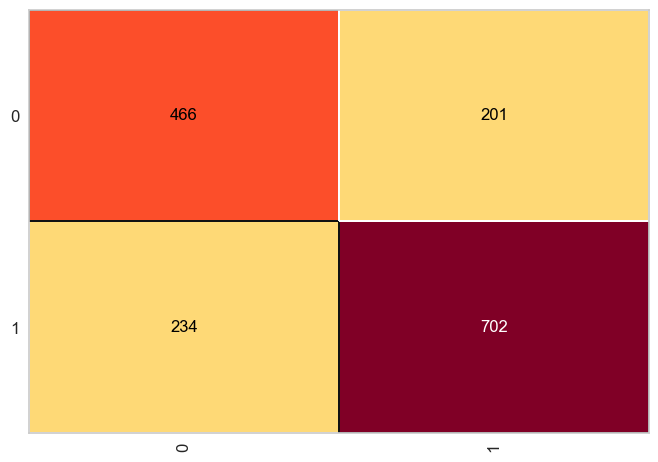

In [ ]:
from sklearn.metrics import confusion_matrix

cm = ConfusionMatrix(model)
cm.score(Cd4AttributesTest, Cd4ClassResultsTest)
y_pred = model.predict(Cd4AttributesTest)
report = classification_report(Cd4ClassResultsTest, y_pred)
print(report)